In [1]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
multi_face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

original_scene_model = models.resnet18(num_classes=365)
original_scene_model.fc = nn.Linear(original_scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
original_scene_model.load_state_dict(scene_state_dict)
original_scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
from deepproblog.network import Network 
import torch.nn.functional as F

original_hf_emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

class MultiFaceWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model

    def forward(self, x):
        if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list):
            # DeepProbLog is passing [face_tensor_list]
            face_tensors = x[0]
        elif isinstance(x, list):
            # Direct call with face tensor list
            face_tensors = x
        else:
            # Single tensor
            face_tensors = [x]
        
        
        # Process each face individually and return all probabilities
        face_probs_list = []
        
        for i, face_tensor in enumerate(face_tensors):
            
            # Add batch dimension if it's a tensor
            if torch.is_tensor(face_tensor):
                face_batch = face_tensor.unsqueeze(0)
                # Get emotion probabilities using the original HF model
                outputs = self.hf_model(face_batch)
                probs = F.softmax(outputs.logits, dim=-1)
                face_probs_list.append(probs.squeeze(0))  # [7]
            else:
                print(f"Warning: face_tensor is not a tensor: {type(face_tensor)}")
        
        if len(face_probs_list) == 0:
            # Fallback - return zeros
            return torch.zeros(1, 7)
        
        # Always return a 2D tensor for consistency: [num_faces, 7]
        result = torch.stack(face_probs_list, dim=0)
        return result

# Create the wrapper with the original HuggingFace model
multi_face_model = MultiFaceWrapper(original_hf_emotion_model)
    
class SceneWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            x = x.unsqueeze(0)
            
        logits = self.model(x)
        probs = F.softmax(logits, dim=-1)
        return probs

scene_model = SceneWrapper(original_scene_model)

In [4]:
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

In [5]:
# train_test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
from mtcnn import MTCNN
# Image access (tensors) - separate classes for different preprocessing
class FindingEmoFaceImages(object):
    def __init__(self, subset):
        self.subset = subset
        self.face_detector = MTCNN()

        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
# Will return a list of tensors corresponding to all the detected faces.
# If no face is detected, just return the tensor of the image.
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect the faces
        face_results = self.face_detector.detect_faces(img)

        # Sort faces by x-coordinate (left to right)
        if len(face_results) > 0:
            face_results.sort(key=lambda face: face['box'][0])

        face_tensors = []

        if len(face_results) > 0:
            for face_result in face_results:
                x, y, w, h = face_result['box']

                # Handle negative coordinates and bounds
                x = max(0, x)
                y = max(0, y)
                x2 = min(img.shape[1], x + w)
                y2 = min(img.shape[0], y + h)

                # Face crop
                face_crop = img[y:y2, x:x2] 
                # Skip if the crop is too small
                if face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue

                # Converting to PIL and process it with HF processor
                face_pil = Image.fromarray(face_crop)
                face_input = emotion_processor(images=face_pil, return_tensors="pt")
                face_tensors.append(face_input['pixel_values'].squeeze(0))

        if len(face_tensors) == 0:
            # Use whole image as fallback
            img_pil = Image.fromarray(img)
            face_input = emotion_processor(images = img_pil, return_tensors="pt")
            face_tensors.append(face_input['pixel_values'].squeeze(0))
            
        return face_tensors

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train = FindingEmoFaceImages("train")
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [7]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

Number of face tensors: 10
Each face tensor shape: torch.Size([3, 224, 224])
Number of face tensors: 10
Ground truth emotion:  Joy


Number of face tensors: 10
Each face tensor shape: torch.Size([3, 224, 224])
Number of face tensors: 10
Ground truth emotion:  Joy


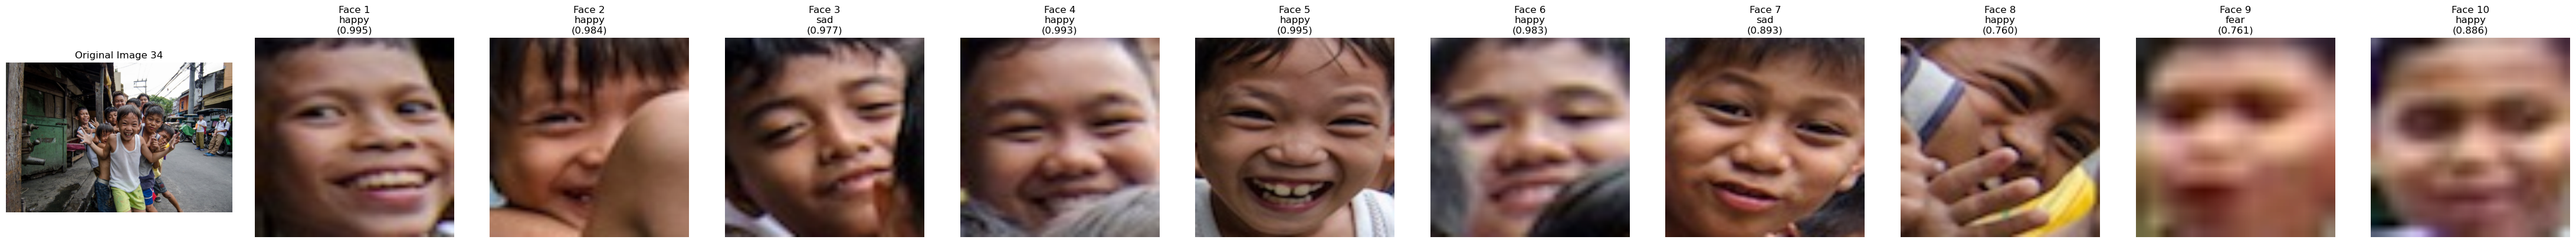


Top 5 emotions for each face:

Face 1:
  1. happy: 0.9946
  2. neutral: 0.0029
  3. sad: 0.0010
  4. disgust: 0.0005
  5. surprise: 0.0004

Face 2:
  1. happy: 0.9844
  2. sad: 0.0086
  3. surprise: 0.0035
  4. neutral: 0.0013
  5. disgust: 0.0010

Face 3:
  1. sad: 0.9766
  2. happy: 0.0159
  3. angry: 0.0021
  4. surprise: 0.0020
  5. neutral: 0.0013

Face 4:
  1. happy: 0.9933
  2. sad: 0.0030
  3. neutral: 0.0020
  4. surprise: 0.0006
  5. disgust: 0.0005

Face 5:
  1. happy: 0.9948
  2. neutral: 0.0023
  3. sad: 0.0013
  4. disgust: 0.0004
  5. angry: 0.0004

Face 6:
  1. happy: 0.9830
  2. sad: 0.0086
  3. surprise: 0.0045
  4. neutral: 0.0018
  5. fear: 0.0009

Face 7:
  1. sad: 0.8933
  2. happy: 0.0948
  3. neutral: 0.0052
  4. surprise: 0.0025
  5. angry: 0.0016

Face 8:
  1. happy: 0.7597
  2. sad: 0.1151
  3. surprise: 0.0989
  4. neutral: 0.0136
  5. fear: 0.0055

Face 9:
  1. fear: 0.7610
  2. neutral: 0.0973
  3. angry: 0.0778
  4. surprise: 0.0453
  5. sad: 0.0076

Fac

In [8]:
test_idx = random.randint(0, 100)
face_tensors = FindingEmoFace_train[(test_idx,)]
print(f"Number of face tensors: {len(face_tensors)}")
print(f"Each face tensor shape: {face_tensors[0].shape}")

image_path = train_df.iloc[test_idx]['image_path']
img_path = os.path.join(base_findingemo_dir, image_path)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Number of face tensors: {len(face_tensors)}")
femo = train_df.iloc[test_idx]['emotion']
print("Ground truth emotion: ", femo)

with torch.no_grad():
    emotion_probs = multi_face_model(face_tensors)

individual_face_predictions = []
individual_face_full_probs = []
for i, face_tensor in enumerate(face_tensors):
    with torch.no_grad():
        face_batch = face_tensor.unsqueeze(0)
        outputs = multi_face_model.hf_model(face_batch)
        face_probs = F.softmax(outputs.logits, dim=-1)
        top_emotion_idx = torch.argmax(face_probs, dim=1).item()
        confidence = torch.max(face_probs).item()
        individual_face_predictions.append((top_emotion_idx, confidence))
        individual_face_full_probs.append(face_probs.squeeze(0)) 

num_faces = len(face_tensors)
plt.figure(figsize=(4 * (num_faces + 1), 4))

# Display original image
plt.subplot(1, num_faces + 1, 1)
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Original Image {test_idx}")

# Display each face tensor with individual predictions
for i, face_tensor in enumerate(face_tensors):
    face_img = face_tensor.permute(1, 2, 0).numpy()
    face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())
    
    # Get individual prediction for this face
    emotion_idx, confidence = individual_face_predictions[i]
    emotion_name = emotion_categories[emotion_idx]
    
    plt.subplot(1, num_faces + 1, i + 2)
    plt.imshow(face_img)
    plt.axis('off')
    plt.title(f'Face {i + 1}\n{emotion_name}\n({confidence:.3f})')

plt.tight_layout()
plt.show()

# Show top 5 emotions for each individual face
print(f"\nTop 5 emotions for each face:")
for i, face_probs in enumerate(individual_face_full_probs):
    print(f"\nFace {i+1}:")
    top_5_emotions = torch.topk(face_probs, k=5)
    for j, (score, idx) in enumerate(zip(top_5_emotions.values, top_5_emotions.indices)):
        print(f"  {j+1}. {emotion_categories[idx.item()]}: {score.item():.4f}")

In [9]:
# Mapping for the scene categories. Read them from ../data/places365/categories_places365.txt
scene_categories = []
with open(os.path.join(script_dir, "../data/places365/categories_places365.txt")) as f:
    for line in f:
        scene = line.strip().split(' ')[0][3:]
        scene_categories.append(scene)

model_scene_to_index = {scene: idx for idx, scene in enumerate(scene_categories)}

In [10]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant
from deepproblog.query import Query
from deepproblog.train import train_model

In [11]:
simple_scene_network = Network(scene_model, "scene_net", batching=True)
individual_face_network = Network(multi_face_model, "multi_face_net", batching=True)

num_emotions = len(emotion_categories)
num_scenes = len(scene_categories)

emotion_indices = list(range(num_emotions))
scene_indices = list(range(num_scenes))

In [12]:
train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

In [13]:
# Create networks for the expert system
multi_face_network = Network(multi_face_model, "multi_face_net", batching=True)
scene_network = Network(scene_model, "scene_net", batching=True)

# Create expert model
model = Model(
    os.path.join(script_dir, "model.pl"),
    [multi_face_network, scene_network]
)
model.set_engine(ExactEngine(model), cache=True)

# Register tensor sources
model.add_tensor_source("train_face", FindingEmoFace_train)
model.add_tensor_source("test_face", FindingEmoFace_test)
model.add_tensor_source("train_scene", FindingEmoScene_train)
model.add_tensor_source("test_scene", FindingEmoScene_test)

Caching ACs


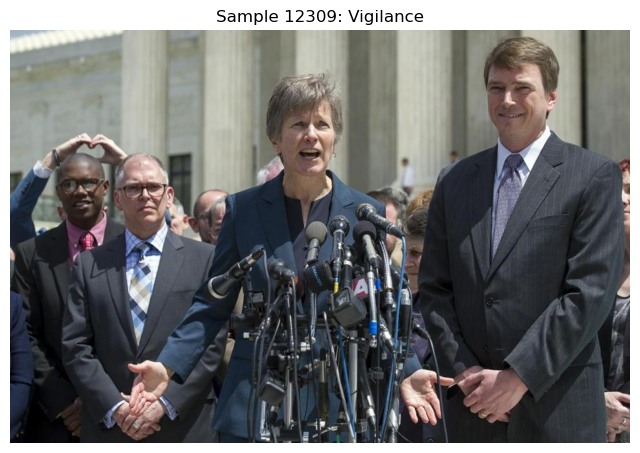

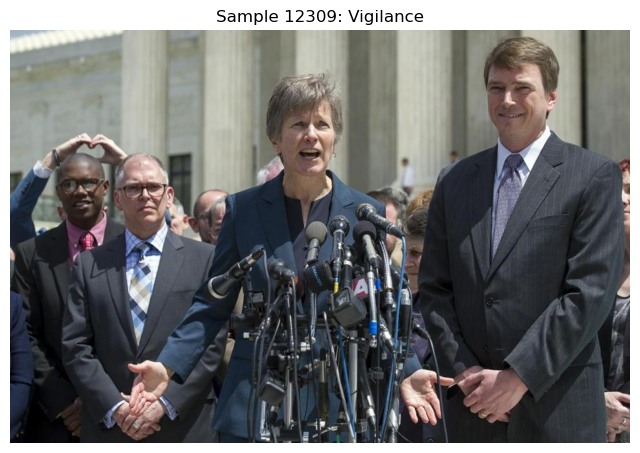

(all_face_emotions(tensor(train_face(12309)),tensor(nn(multi_face_net,[tensor(train_face(12309))]))), 1.0)


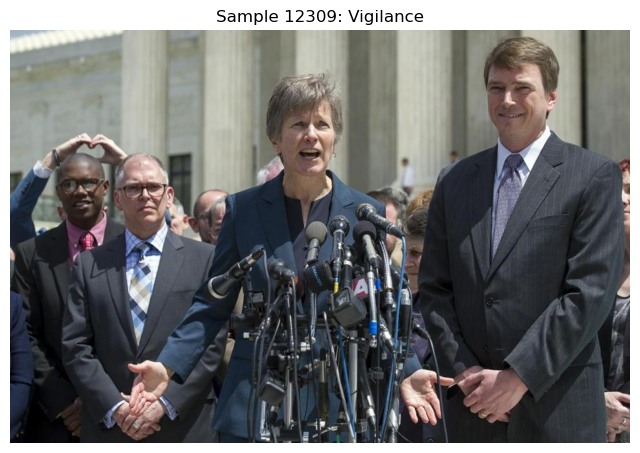

(all_face_emotions(tensor(train_face(12309)),tensor(nn(multi_face_net,[tensor(train_face(12309))]))), 1.0)


c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\deepproblog\semiring\graph_semiring.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return -self.eps <= float(a) <= self.eps


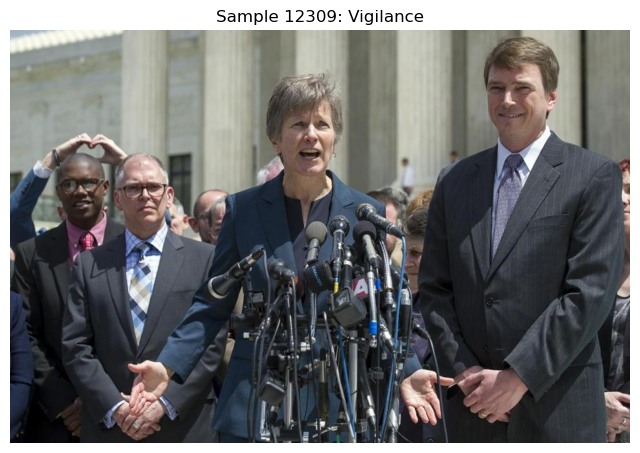

(all_face_emotions(tensor(train_face(12309)),tensor(nn(multi_face_net,[tensor(train_face(12309))]))), 1.0)


c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\deepproblog\semiring\graph_semiring.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return -self.eps <= float(a) <= self.eps



Scene Prediction Distribution (Top 5):
  legislative_chamber: 0.2907
  embassy: 0.2047
  nursing_home: 0.1009
  conference_center: 0.0727
  campus: 0.0592


In [14]:
# Simple test showing only distributions
train_sample_idx = random.randint(0, len(train_df) - 1)

# display original image
img_path = os.path.join(base_findingemo_dir, train_df.iloc[train_sample_idx]['image_path'])
img = cv2.imread(img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Sample {train_sample_idx}: {train_df.iloc[train_sample_idx]['emotion']}")
plt.show()

# Face emotion distributions using DeepProbLog query
face_query = Query(
    Term("all_face_emotions",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         None),
    substitution={}
)

face_results = model.solve([face_query])
face_dict = face_results[0].result
for item in face_dict.items():
    print(item)

# Scene prediction distribution
scene_query = Query(
    Term("scene_prediction",
         Term("tensor", Term("train_scene", Constant(train_sample_idx))),
         None),
    substitution={}
)

scene_results = model.solve([scene_query])
scene_dict = scene_results[0].result
sorted_scenes = sorted(scene_dict.items(), key=lambda x: x[1], reverse=True)

print("\nScene Prediction Distribution (Top 5):")
for i, (key, prob) in enumerate(sorted_scenes[:5]):
    scene_idx = int(str(key).split(',')[-1].rstrip(')'))
    scene_name = scene_categories[scene_idx]
    print(f"  {scene_name}: {prob:.4f}")